<a href="https://colab.research.google.com/github/zeynabyousefi/AdvanceNlp/blob/main/SpeechClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speech Classification

---

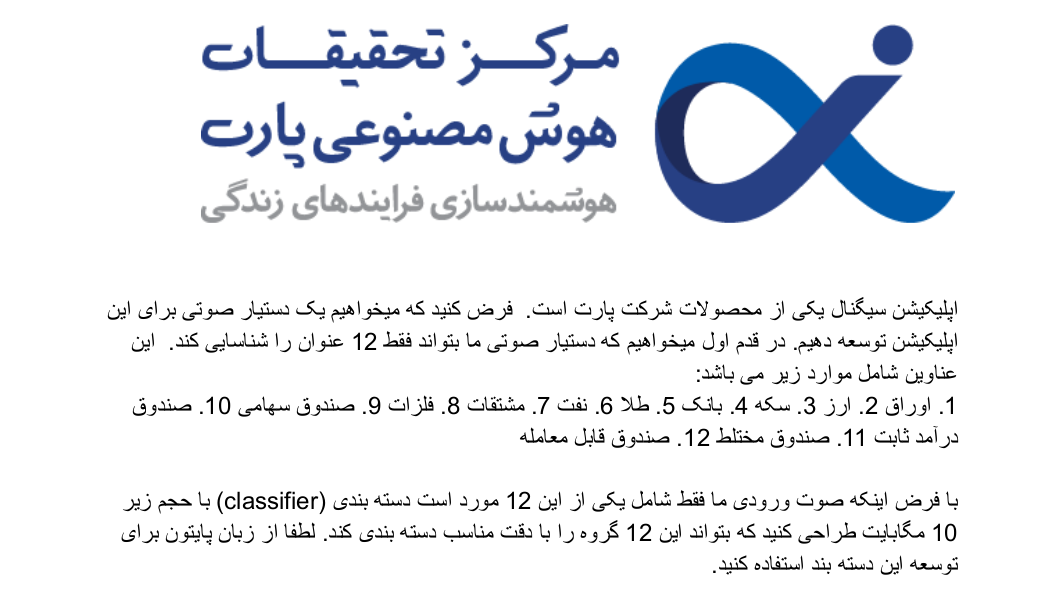

In [ ]:
import os
import sys
import re
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm

from sklearn.metrics import accuracy_score,\
 precision_score , recall_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchaudio
from torchaudio.transforms import MelSpectrogram
import torchaudio.transforms as T
from torch.nn.utils.rnn import pad_sequence
from torchvision import models
from torchvision.transforms import Compose, Lambda

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

import seaborn as sns

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available")

GPU is available


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# List files in the specified folder
drive_path = '/content/drive/My Drive/SpeechClassification'

# Check if the path exists
if os.path.exists(drive_path):
    files = os.listdir(drive_path)
    print(files)
else:
    print(f"The specified path '{drive_path}' does not exist.")

Mounted at /content/drive
['annotation_file.csv', 'annotation_file.gsheet', '.ipynb_checkpoints', '12words', 'train_dataset', 'test_dataset', 'val_dataset']


In [ ]:
root_dir=  "/content/drive/MyDrive/SpeechClassification/12words" # The file of data # The file of data
annotation_file = "/content/drive/MyDrive/SpeechClassification/annotation_file.csv"

In [ ]:
#describe of data
df = pd.read_csv(annotation_file)
df.head(12)

,label,annotations
0,0,اوراق
1,1,ارز
2,2,سکه
3,3,بانک
4,4,طلا
5,5,نفت
6,6,مشتقات
7,7,فلزات
8,8,صندوق سهامی
9,9,صندوق درآمد ثابت


فایل های داده شده از شماره ۱تا ۱۹ هستند  در صورتی که ما ۱۲ فولدر داریم  و این عدم رعایت ترتیب در نام گذاری با این تابع حل میشود و میتوان فایل ها را مرتب کرد

In [ ]:
def rename_files(root_dir):
      subdirs = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

      # Sort the subdirectories based on their current names
      sorted_subdirs = sorted(subdirs, key=lambda x: int(x.split('-')[0]))

      # Rename the subdirectories and their contents
      for i, old_dir in enumerate(sorted_subdirs, start=1):
          old_dir_path = os.path.join(root_dir, old_dir)
          new_dir = str(i)
          new_dir_path = os.path.join(root_dir, new_dir)
          # Rename the folder
          os.rename(old_dir_path, new_dir_path)
          # Rename the contents inside the folder
          for file_name in os.listdir(new_dir_path):
            file_path = os.path.join(new_dir_path, file_name)

            # Extract the number from the file name using regular expression
            match = re.search(r'\d+', file_name)
            if match:
                file_number = match.group()
                new_file_name = f"{file_number}_{i}.mp3"
                new_file_path = os.path.join(new_dir_path, new_file_name)
                os.rename(file_path, new_file_path)


new_files = rename_files(root_dir)


In [ ]:
category_sample_rates = {}
parent_folder = root_dir
# Iterate through subfolders
for subfolder in os.listdir(parent_folder):
    subfolder_path = os.path.join(parent_folder, subfolder)

    # Check if the item is a subfolder
    if os.path.isdir(subfolder_path):


        # Initialize a list to store sample rates for the current category
        category_sample_rates[subfolder] = []

        # Iterate through audio files in the subfolder
        for filename in os.listdir(subfolder_path):
            if filename.endswith(".mp3"):  # assuming your audio files are in mp3 format
                audio_file_path = os.path.join(subfolder_path, filename)

                # Get information about the audio file
                info = torchaudio.info(audio_file_path)

                # Extract the sample rate and add it to the list for the current category
                sample_rate = info.sample_rate
                category_sample_rates[subfolder].append(sample_rate)


# Print the collected sample rates for each category
print("\nSample Rates for Each Category:")
for category, sample_rates in category_sample_rates.items():
    unique_sample_rates = set(sample_rates)
    print(f"{category}: {unique_sample_rates}")


Sample Rates for Each Category:
1: {44100}
2: {44100}
3: {44100}
4: {44100}
5: {44100}
6: {44100}
7: {44100}
8: {44100}
9: {44100}
10: {44100}
11: {44100}
12: {44100}


All data has same Sample Rates

In [ ]:
sample_rate = 44100

In [ ]:
# we need a label2idx dictionary that you must implement here
df = pd.read_csv(annotation_file, sep=None, header=0, names=['annotations'])

label2idx = {label: torch.tensor(idx+1) for idx, label in enumerate(df['annotations'])}
label2idx


<ipython-input-11-e3533d1cb9d1>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(annotation_file, sep=None, header=0, names=['annotations'])


{'اوراق': tensor(1),
 'ارز': tensor(2),
 'سکه': tensor(3),
 'بانک': tensor(4),
 'طلا': tensor(5),
 'نفت': tensor(6),
 'مشتقات ': tensor(7),
 'فلزات ': tensor(8),
 'صندوق سهامی': tensor(9),
 'صندوق درآمد ثابت ': tensor(10),
 'صندوق مختلط': tensor(11),
 'صندوق قابل معامله': tensor(12)}

پیش پردازش  و خواندن داده

In [ ]:
class AudiCreateDataset(Dataset):
    def __init__(self, root_dir=None, file_list=None):
        self.root_dir = root_dir
        self.file_list = file_list if file_list else self.create_file_list()


    def create_file_list(self):
        if not self.root_dir:
            raise ValueError("root_dir must be provided.")

        file_list = []
        for class_name in sorted(os.listdir(self.root_dir)):
            class_path = os.path.join(self.root_dir, class_name)
            for file_name in os.listdir(class_path):
                file_path = os.path.join(class_path, file_name)
                label = int(file_name.split('_')[1].split('.')[0]) - 1  # Extract label from filename
                file_list.append((str(file_path), label))
        return file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
          file_path, label = self.file_list[idx]
          waveform, sample_rate = torchaudio.load(file_path)

          return waveform, label



In [ ]:
#create dataset
dataset = AudiCreateDataset(root_dir=root_dir)

## Split data to train,test,validation

In [ ]:
# Assuming your dataset is a list of (data, label) pairs
data, labels = zip(*dataset)

# Use StratifiedShuffleSplit to split the data
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)

for train_index, test_index in sss.split(data, labels):
    train_temp_data, test_data = [data[i] for i in train_index], [data[i] for i in test_index]
    train_temp_labels, test_labels = [labels[i] for i in train_index], [labels[i] for i in test_index]

# Further split the temporary set into training and validation sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)

for train_index, val_index in sss.split(train_temp_data, train_temp_labels):
    train_data, val_data = [train_temp_data[i] for i in train_index], [train_temp_data[i] for i in val_index]
    train_labels, val_labels = [train_temp_labels[i] for i in train_index], [train_temp_labels[i] for i in val_index]



In [ ]:
# Now, you have balanced train, val, and test sets
train_data = list(zip(train_data, train_labels))
valid_data = list(zip(val_data, val_labels))
test_data = list(zip(test_data, test_labels))

print("Length of Train Dataset:", len(train_data))
print("Length of Test Dataset:", len(test_data))
print("Length of Validation Dataset:", len(valid_data))

Length of Train Dataset: 346
Length of Test Dataset: 72
Length of Validation Dataset: 62


### data preprocessing

In [ ]:
class DatasetPreprocessing(Dataset):
    def __init__(self, data_list, transform=None, augmentation=None):
        self.data_list = data_list
        self.transform = transform
        self.augmentation = augmentation

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        data, label = self.data_list[idx]

        # Apply data augmentation on-the-fly
        if self.augmentation:
            mel_spectrogram = self.augmentation(data)
            # Replicate the channel
            mel_spectrogram_replicated = mel_spectrogram.repeat(3, 1, 1)

            return mel_spectrogram_replicated, label

        # Apply other transformations if specified
        if self.transform:
            mel_spectrogram = self.transform(data)
            mel_spectrogram_replicated = mel_spectrogram.repeat(3, 1, 1)

            return mel_spectrogram_replicated, label

        return data, label



In [ ]:

def pad_sequence(batch, target_size=(224, 224), padding_value=0.):
    # Find the maximum size along each dimension
    max_size = torch.tensor([item.shape for item in batch]).max(0).values.tolist()

    # Calculate the padding amounts to make the dimensions multiples of 32
    pad_height = (32 - (max_size[-2] % 32)) % 32
    pad_width = (32 - (max_size[-1] % 32)) % 32

    # Pad each item in the batch to have the same size
    padded_batch = [F.pad(item, (0, pad_width, 0, pad_height)) for item in batch]

    # Resize or crop each item to the target size
    resized_batch = [F.interpolate(item.unsqueeze(0), size=target_size, mode='bilinear', align_corners=False).squeeze(0) for item in padded_batch]

    # Stack the resized/cropped items to create a batched tensor
    padded_batch_rgb = torch.stack(resized_batch)

    return padded_batch_rgb


def collate_fn(batch):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        tensors += [waveform]
        targets += [torch.tensor(label)]



    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors).to(device)
    targets = torch.tensor(targets, dtype=torch.long).to(device)


    return tensors, targets



In [ ]:
#Data agumentation

data_agu = Compose([
    # torchaudio.transforms.MelSpectrogram(sample_rate=44100, n_fft=400, hop_length=160, n_mels=128),
    T.TimeMasking(time_mask_param=75),
    T.MelSpectrogram(sample_rate=44100, n_mels=128, hop_length=160),
    T.FrequencyMasking(freq_mask_param=65),


    # Add any other augmentations you need
])

data_transform = Compose([

    T.MelSpectrogram(sample_rate=44100, n_mels=128, hop_length=160),

])

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [ ]:

valid_dataset = DatasetPreprocessing(data_list=valid_data,
                             transform=data_transform)

train_dataset = DatasetPreprocessing(data_list=train_data,
                             augmentation=data_agu )

test_dataset = DatasetPreprocessing(data_list=test_data,
                                    transform=data_transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                          collate_fn=collate_fn,
                          )
test_loader = DataLoader(test_dataset, batch_size=32,
                         shuffle=False,collate_fn=collate_fn)

valid_loader = DataLoader(valid_dataset, batch_size=32,
                          shuffle=False,collate_fn=collate_fn)

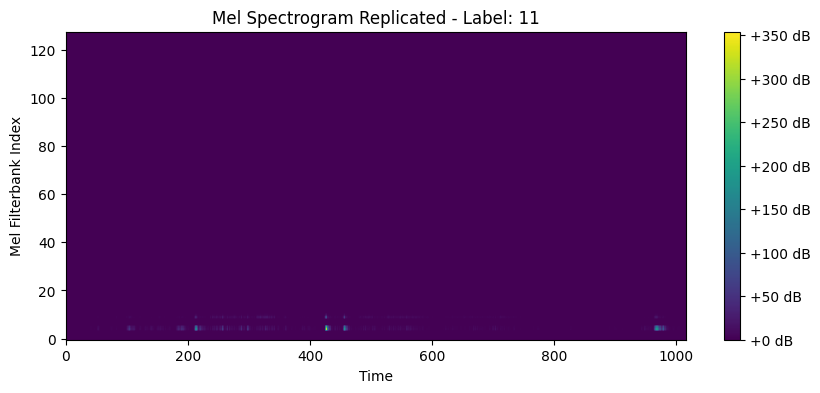

In [ ]:
#Example of Mel-SPECTOGRAM

def plot_mel_spectrogram(mel_spectrogram, label):
    plt.figure(figsize=(10, 4))
    plt.imshow(mel_spectrogram[0].numpy(), cmap='viridis', origin='lower', aspect='auto')
    plt.title(f'Mel Spectrogram Replicated - Label: {label}')
    plt.xlabel('Time')
    plt.ylabel('Mel Filterbank Index')
    plt.colorbar(format="%+2.0f dB")
    plt.show()



# Choose an index for the example you want to visualize
example_index = 0

# Get the example from the dataset
example_data, example_label = train_dataset[-1]

# Plot the mel spectrogram
plot_mel_spectrogram(example_data, example_label)

In [ ]:
# Define ResNet-50 model
model = models.resnet50(pretrained=True)

model.to(device)
num_classes = 12  # Modify this according to your dataset
model.fc = nn.Sequential(
    nn.Dropout(p=0.75),  # Add a dropout layer with a dropout probability of 0.5
    nn.Linear(model.fc.in_features, num_classes)
)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train Epoch: 1 -- Batch: 0/11 -- Train Accuracy: 0.0938 -- Train Loss: 2.545991
Train Epoch: 1 -- Batch: 2/11 -- Train Accuracy: 0.0833 -- Train Loss: 2.517651
Train Epoch: 1 -- Batch: 4/11 -- Train Accuracy: 0.1062 -- Train Loss: 2.534913
Train Epoch: 1 -- Batch: 6/11 -- Train Accuracy: 0.0938 -- Train Loss: 2.513638
Train Epoch: 1 -- Batch: 8/11 -- Train Accuracy: 0.0764 -- Train Loss: 2.536239
Train Epoch: 1 -- Batch: 10/11 -- Train Accuracy: 0.0723 -- Train Loss: 2.563603
Val Epoch: 1 -- Val Accuracy: 0.0806 -- Val Loss: 2.493992
Train Epoch: 2 -- Batch: 0/11 -- Train Accuracy: 0.2188 -- Train Loss: 2.438993
Train Epoch: 2 -- Batch: 2/11 -- Train Accuracy: 0.1458 -- Train Loss: 2.538930
Train Epoch: 2 -- Batch: 4/11 -- Train Accuracy: 0.1125 -- Train Loss: 2.532687
Train Epoch: 2 -- Batch: 6/11 -- Train Accuracy: 0.1071 -- Train Loss: 2.545253
Train Epoch: 2 -- Batch: 8/11 -- Train Accuracy: 0.1146 -- Train Loss: 2.516163
Train Epoch: 2 -- Batch: 10/11 -- Train Accuracy: 0.1127 -- 

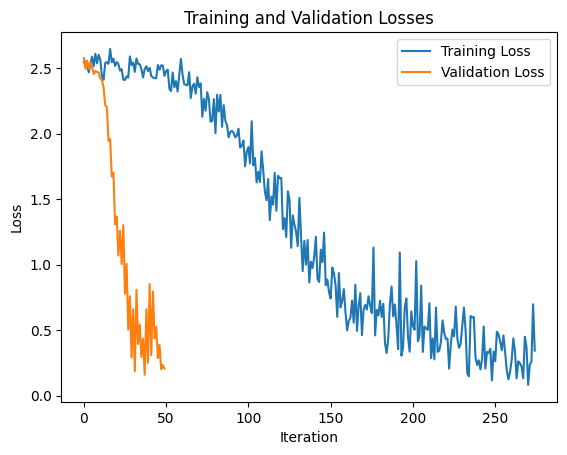

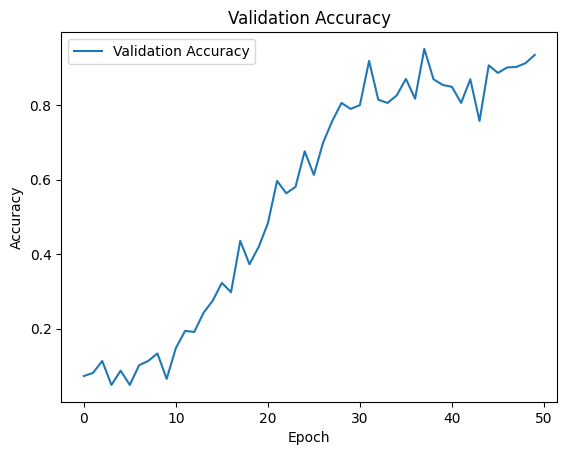

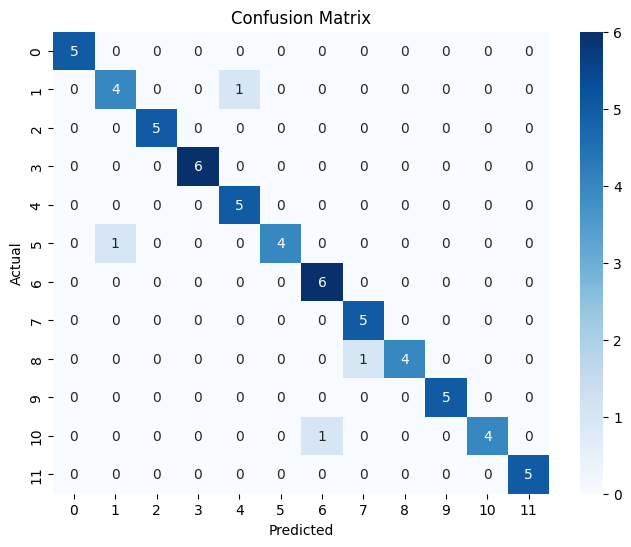

In [ ]:

class Recognizer:
    def __init__(self, model, train_loader, valid_loader,test_loader, criterion, optimizer, device="cuda"):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.valid_loader = valid_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.train_losses = []
        self.valid_losses = []
        self.test_losses = []
        self.test_accuracies = []
        self.accuracies = []


    def train(self, epoch):
        self.model.train()

        truths = []
        preds = []
        for batch_idx, (data, target) in enumerate(self.train_loader):
            data, target = data.to(self.device), target.to(self.device)

            output = self.model(data)

            truths.extend(target.cpu().numpy())
            preds.extend(output.argmax(dim=-1).cpu().numpy())

            loss = self.criterion(output, target)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # Print training stats
            log_interval = len(self.train_loader) // 4
            if batch_idx % log_interval == 0:
                accuracy = accuracy_score(truths, preds)

                print(f"Train Epoch: {epoch} -- Batch: {batch_idx}/{len(self.train_loader)} "
                      f"-- Train Accuracy: {accuracy:.4f} -- Train Loss: {loss.item():.6f}")

            self.train_losses.append(loss.item())

        accuracy = accuracy_score(truths, preds)
        self.accuracies.append(accuracy)

    def validate(self, epoch):
        self.model.eval()

        truths = []
        preds = []
        with torch.no_grad():
            for data, target in self.valid_loader:
                data, target = data.to(self.device), target.to(self.device)

                output = self.model(data)

                truths.extend(target.cpu().numpy())
                preds.extend(output.argmax(dim=-1).cpu().numpy())

                loss = self.criterion(output, target)
                self.valid_losses.append(loss.item())

        accuracy = accuracy_score(truths, preds)
        print(f"Val Epoch: {epoch} -- Val Accuracy: {accuracy:.4f} -- Val Loss: {self.valid_losses[-1]:.6f}")
        self.accuracies.append(accuracy)

    def test(self):
        self.model.eval()

        truths = []
        preds = []
        with torch.no_grad():
            for data, target in self.test_loader:
                data, target = data.to(self.device), target.to(self.device)

                output = self.model(data)

                truths.extend(target.cpu().numpy())
                preds.extend(output.argmax(dim=-1).cpu().numpy())

                loss = self.criterion(output, target)
                self.test_losses.append(loss.item())

        accuracy = accuracy_score(truths, preds)
        print(f"Test Accuracy: {accuracy:.4f} -- Test Loss: {self.test_losses[-1]:.6f}")
        self.test_accuracies.append(accuracy)

    def plot_losses(self):
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.valid_losses, label='Validation Loss')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Losses')
        plt.show()

    def plot_accuracies(self):
        plt.plot(self.accuracies, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Validation Accuracy')
        plt.show()

    def plot_confusion_matrix(self):
        self.model.eval()

        truths = []
        preds = []
        with torch.no_grad():
            for data, target in self.valid_loader:
                data, target = data.to(self.device), target.to(self.device)

                output = self.model(data)

                truths.extend(target.cpu().numpy())
                preds.extend(output.argmax(dim=-1).cpu().numpy())

        cm = confusion_matrix(truths, preds)
        class_names = [str(i) for i in range(len(cm))]

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

    def save_model(self, path):
        torch.save(self.model.state_dict(), path)
        print(f"Model saved at: {path}")


trainer = Recognizer(model, train_loader, valid_loader,test_loader, criterion, optimizer)

# Training loop
n_epochs = 25
for epoch in range(1, n_epochs + 1):
    trainer.train(epoch)
    trainer.validate(epoch)
#test model
trainer.test()
# Save the trained model
trainer.save_model('/content/drive/MyDrive/SpeechClassification/trained_model.pth')
# Plot losses and accuracies
trainer.plot_losses()
trainer.plot_accuracies()
trainer.plot_confusion_matrix()